## Classifying the images by training the SVM on the features extracted by the CNNs

First, we import the appropriate libraries needed for scaling the data, training the SVM and evaluating performance.

In [7]:
import numpy as np
import seaborn as sns

from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

## Loading the features extracted with the CNNs

Now the features has been extracted with the base CNNs that were trained on the dataset, by removing their last classification layer.

These features have been saved to their respective directories and can be selectively called to train the SVM.

Selecting the desired feature set is simple, simply uncomment only the "load_features_dir" which you want to select and run the cell.

StandarScaler will scale the extracted features.

In [8]:
#load_features_dir = "inceptionv3"
#load_features_dir = "inceptionresnetv2"
load_features_dir = "xception"

train_features = np.load(f'extracted_features/{load_features_dir}/train_features.npy')
val_features = np.load(f'extracted_features/{load_features_dir}/val_features.npy')
test_features = np.load(f'extracted_features/{load_features_dir}/test_features.npy')

train_labels = np.load(f'extracted_features/{load_features_dir}/train_labels.npy')
val_labels = np.load(f'extracted_features/{load_features_dir}/val_labels.npy')
test_labels = np.load(f'extracted_features/{load_features_dir}/test_labels.npy')

scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
val_features_scaled = scaler.fit_transform(val_features)
test_features_scaled = scaler.transform(test_features)

## Grid Search

Once the features are loaded and scaled, we can start a grid search.

The grid search will look through a number of different kernels and various hyperparameter combinations to find the one that gives the best results.

There are 3 rounds to the grid search.

The first one is used to set the magnitude of the parameter values.

The second one then searches the neighbourhood of the best values from the first round, in a range od +-20%.

The third round then uses the best values from the second round and reduces the search to +-10%.

In [9]:
param_grid_1 = {
    'C': [1_000_000_000_000, 10_000_000_000_000, 100_000_000_000_000],
    'gamma': [0.000_000_000_000_001, 0.000_000_000_000_000_1, 0.000_000_000_000_000_01],
    'kernel': ['rbf', 'sigmoid']
}

grid_search_1 = GridSearchCV(SVC(), param_grid_1, refit = True, cv = 5, verbose = 3, n_jobs = 12)
grid_search_1.fit(train_features_scaled, train_labels)
print("Best parameter values from first round of grid search:", grid_search_1.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameter values from first round of grid search: {'C': 100000000000000, 'gamma': 1e-15, 'kernel': 'sigmoid'}


In [10]:
c_best_1 = grid_search_1.best_params_['C']
gamma_best_1 = grid_search_1.best_params_['gamma']

param_grid_2 = {
    'C': [c_best_1 * 0.8, c_best_1 * 0.9, c_best_1, c_best_1 * 1.1, c_best_1 * 1.2],
    'gamma': [gamma_best_1 * 0.8, gamma_best_1 * 0.9, gamma_best_1, gamma_best_1 * 1.1, gamma_best_1 * 1.2],
    'kernel': [grid_search_1.best_params_['kernel']]
}

grid_search_2 = GridSearchCV(SVC(), param_grid_2, refit = True, cv = 5, verbose = 3, n_jobs = 12)
grid_search_2.fit(train_features_scaled, train_labels)
print("Best parameter values from second round of grid search:", grid_search_2.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameter values from second round of grid search: {'C': 120000000000000.0, 'gamma': 1.2e-15, 'kernel': 'sigmoid'}


In [11]:
c_best_2 = grid_search_2.best_params_['C']
gamma_best_2 = grid_search_2.best_params_['gamma']

param_grid_3 = {
    'C': [c_best_2 * 0.9, c_best_2 * 0.95, c_best_2, c_best_2 * 1.05, c_best_2 * 1.1],
    'gamma': [gamma_best_2 * 0.9, gamma_best_2 * 0.95, gamma_best_2, gamma_best_2 * 1.05, gamma_best_2 * 1.1],
    'kernel': [grid_search_2.best_params_['kernel']]
}
grid_search_3 = GridSearchCV(SVC(), param_grid_3, refit = True, cv = 5, verbose = 3, n_jobs = 12)
grid_search_3.fit(train_features_scaled, train_labels)
print("Best parameter values from third round of grid search:", grid_search_3.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameter values from third round of grid search: {'C': 108000000000000.0, 'gamma': 1.3200000000000001e-15, 'kernel': 'sigmoid'}


Finally, using the best hyperparameter values obtained from the grid search, we generate a classification report and a visual confusion matrix.

CNN (xception) + SVM:

Classification Report:
               precision    recall  f1-score   support

        Fake     0.9986    0.9233    0.9595      1500
        Real     0.9287    0.9987    0.9624      1500

    accuracy                         0.9610      3000
   macro avg     0.9636    0.9610    0.9609      3000
weighted avg     0.9636    0.9610    0.9609      3000



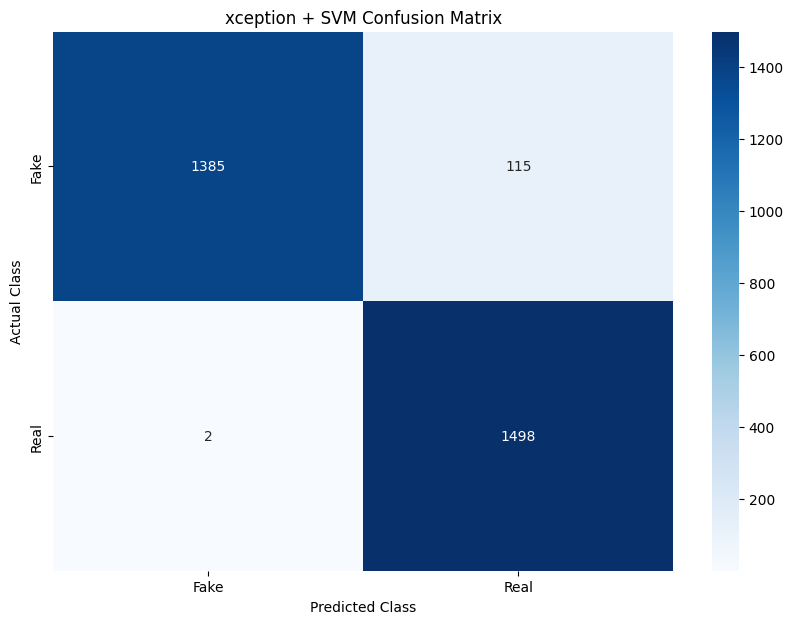

In [12]:
trained_svm = SVC(**grid_search_3.best_params_)
trained_svm.fit(val_features_scaled, val_labels)
test_predictions = trained_svm.predict(test_features_scaled)

print(f"CNN ({load_features_dir}) + SVM:\n")
print("Classification Report:\n", classification_report(test_labels, test_predictions, target_names = ['Fake', 'Real'], digits = 4))

conf_matrix = confusion_matrix(test_labels, test_predictions)

plt.figure(figsize = (10, 7))
sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = "Blues", xticklabels = ['Fake', 'Real'], yticklabels = ['Fake', 'Real'])
plt.title(f'{load_features_dir} + SVM Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()